# Logistic regression using numeric attributes

It's time to train a logistic classificator. We'll be using the pivot table data from the we made in the previous notebook. We'll also add some features to the model (basic feature engineering).

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sb
from datetime import datetime
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score

sb.set_style('dark')
plt.rcParams['figure.figsize'] = (14,10)

First, let's make the pivot table we'll use for feature engineering.

In [2]:
data = pd.read_csv('../data/data.csv')
data = data[['week', 'user', 'tweets', 'total_length', 'total_words']]

In [3]:
%%time
data['week'] = data['week'].apply(lambda w: datetime.strptime(w, '%Y-%m-%d 00:00:00').isocalendar()[1])

CPU times: user 4min 18s, sys: 1.93 s, total: 4min 20s
Wall time: 4min 21s


Get rid of the 43th week because there's a large gap between 36th and 43th week.

In [4]:
data = data[data['week'] < 40]

In [5]:
pivot = data.pivot_table(index='user', columns='week', aggfunc=np.sum, fill_value=0)
pivot.head()

tweets                            ... total_words            \
week                23 24 25 26 27 28 29 30 31 32 ...          27 28 29  30   
user                                              ...                         
 bdogg               0  0  0  0  0  0  0  0  0  0 ...           0  0  0   0   
0                    0  0  1  0  0  0  0  0  0  0 ...           0  0  0   0   
00000000             0  0  0  0  0  0  0  1  0  1 ...           0  0  0  10   
000000000000111      0  0  0  0  0  0  0  0  0  0 ...           0  0  0   0   
000000000101010      0  0  0  0  0  0  0  0  0  1 ...           0  0  0   0   

                                      
week            31 32  33 34  35  36  
user                                  
 bdogg           0  0   0  0   0  24  
0                0  0   0  0   0   0  
00000000         0  5   0  0  12  17  
000000000000111  0  0  12  0   0   0  
000000000101010  0  5   0  0   0   0  

[5 rows x 42 columns]

Now make the target series and drop it from the pivot data.

In [6]:
target = pivot['tweets'][36] > 0
target.shape

(8261630,)

In [7]:
pivot = pivot.drop(36, axis=1, level=1)

## Normalization

In the previous notebook, we plotted the total number of tweets per week.

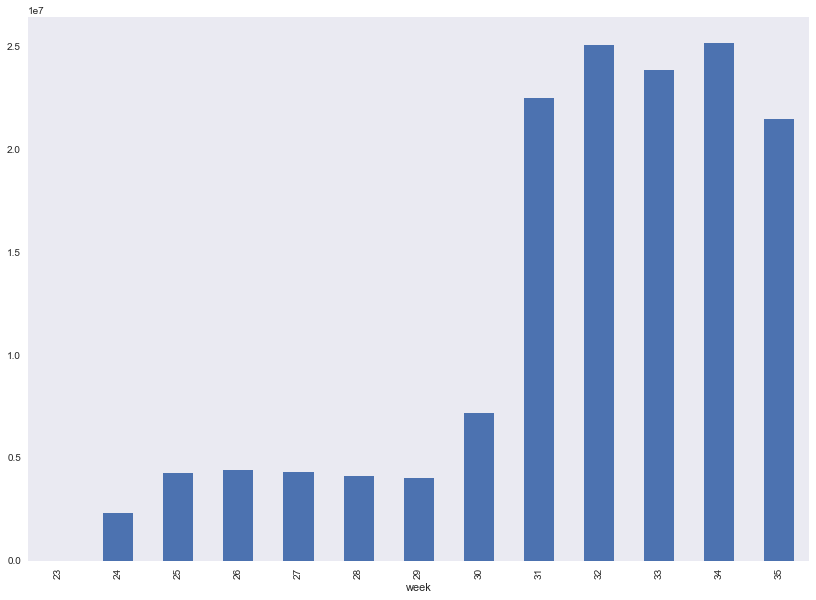

In [8]:
pivot['tweets'].sum().plot(kind='bar')

We can see that the number of tweets is not the same across all weeks. So let's normalize the dataset – divide the numbers by their total sums per week.

In [9]:
normalized = pivot.div(pivot.sum())

In [10]:
normalized['tweets'].sum()

week
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
30    1.0
31    1.0
32    1.0
33    1.0
34    1.0
35    1.0
dtype: float64

Now let's check the target values and their counts.

In [11]:
np.unique(target, return_counts=True)

(array([False,  True], dtype=bool), array([7305450,  956180]))

The dataset is not balanced. There are almost ten times more inactive users than there are active. Before training the model, let's balance these classes.

In [12]:
normalized_target = normalized
normalized_target['target'] = target

In [13]:
active = normalized_target[target == True]
inactive = normalized_target[target == False]

In [14]:
active.shape[0]

956180

In [15]:
inactive.shape[0]

7305450

In [16]:
inactive = inactive.sample(active.shape[0])

In [17]:
inactive.shape[0]

956180

In [18]:
balanced = pd.concat([active, inactive])

In [19]:
balanced.shape

(1912360, 40)

## Training

Now the dataset is normalized and balanced. We can train the logistic classificator and see how it performs.

In [20]:
train_rows = np.random.rand(balanced.shape[0]) < 0.7
train = balanced[train_rows].drop('target', axis=1)
train_target = balanced[train_rows]['target']
test = balanced[~train_rows].drop('target', axis=1)
test_target = balanced[~train_rows]['target']

In [21]:
%%time
reg = LogisticRegressionCV()
model = reg.fit(train, train_target)

CPU times: user 13 s, sys: 1.83 s, total: 14.8 s
Wall time: 10.7 s


Test the trained model using various metrics.

In [22]:
predicted = model.predict(test)

In [23]:
accuracy_score(test_target, predicted)

0.49947523327316934

In [24]:
f1_score(test_target, predicted, average='macro')

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.3331000220543

In [25]:
f1_score(test_target, predicted, average='micro')

0.49947523327316934

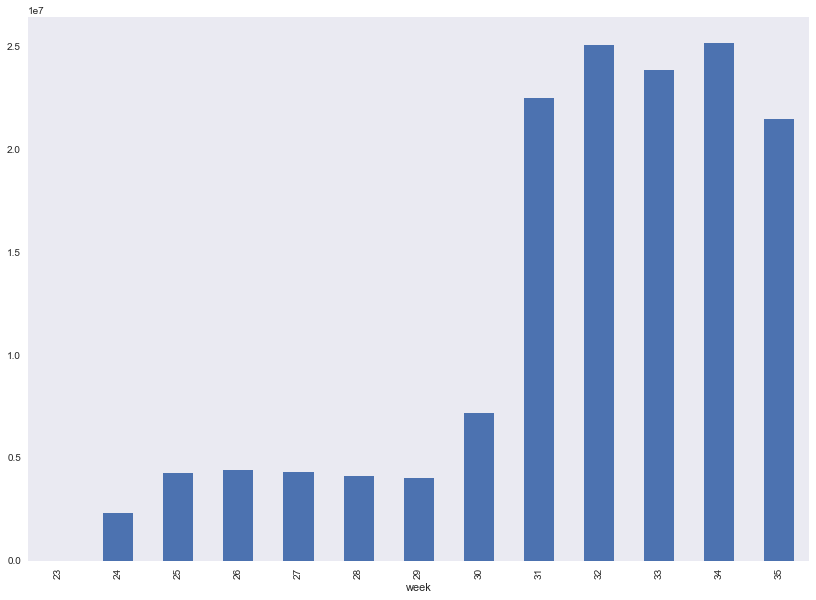

In [26]:
sb.set_style('w')
pivot['tweets'].sum().plot(kind='bar')